In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import h5py
from tqdm import tqdm

In [2]:
file_path = '/Users/janniskerl/Downloads/HCF_CP2005_single.mat'

with h5py.File(file_path, 'r') as f:
    # Check the keys (you already saw: 'HCF_CP_single')
    print("Keys:", list(f.keys()))
    
    # Load the dataset
    dataset = f['HCF_CP_single']

    # Convert to NumPy array
    data = np.array(dataset)

    print("Shape of data:", data.shape)


Keys: ['HCF_CP_single']
Shape of data: (8760, 800, 400)


In [3]:
# Rearrange dimensions to: (lat, lon, time)
data = np.transpose(data, (2, 1, 0))  # Now: shape = (400, 800, 8760)
print("Reordered shape:", data.shape)


Reordered shape: (400, 800, 8760)


In [4]:
# Load EU NUTS2 data (excluding GB)
nuts2_eu_path = 'NUTS_RG_60M_2024_3035.geojson'
nuts2_eu_gdf = gpd.read_file(nuts2_eu_path)
nuts2_eu_gdf = nuts2_eu_gdf[nuts2_eu_gdf['LEVL_CODE'] == 2]  # Keep only NUTS2 regions

# Load GB-specific NUTS2 data
nuts2_gb_path = 'NUTS_RG_60M_2021_3035.geojson'
nuts2_gb_gdf = gpd.read_file(nuts2_gb_path)
nuts2_gb_gdf = nuts2_gb_gdf[nuts2_gb_gdf['LEVL_CODE'] == 2]  # Keep only NUTS2 regions 
nuts2_gb_gdf = nuts2_gb_gdf[nuts2_gb_gdf['CNTR_CODE'] == 'UK']

# Merge EU and GB NUTS2 regions
nuts2_gdf = pd.concat([nuts2_eu_gdf, nuts2_gb_gdf], ignore_index=True)
nuts2_gdf = nuts2_gdf.drop_duplicates(subset=['NUTS_ID'])
nuts2_gdf

nuts2_gdf = nuts2_gdf.to_crs("EPSG:4326")  # Required for spatial join

In [5]:
"Find conversion in https://ars.els-cdn.com/content/image/1-s2.0-S0306261924005026-mmc1.pdf"

# Create index arrays for the grid (400 x 800)
lat_indices = np.arange(400)
lon_indices = np.arange(800)

# Compute lat/lon using the provided formulas
resolution = 0.45
lat_values = (lat_indices + 1 - 200) * resolution - resolution / 2  # shape: (400,)
lon_values = (lon_indices + 1 - 400) * resolution - resolution / 2  # shape: (800,)

# Create 2D meshgrid for lat/lon
lat_mesh, lon_mesh = np.meshgrid(lat_values, lon_values, indexing='ij')  # shape: (400, 800)

# Flatten for GeoDataFrame
lat_flat = lat_mesh.ravel()
lon_flat = lon_mesh.ravel()
lat_idx_flat = np.repeat(lat_indices, 800)
lon_idx_flat = np.tile(lon_indices, 400)

# Create point geometries
grid_points = [Point(lon, lat) for lon, lat in zip(lon_flat, lat_flat)]

# Create GeoDataFrame of grid points
grid_points_gdf = gpd.GeoDataFrame({
    'lat_idx': lat_idx_flat,
    'lon_idx': lon_idx_flat
}, geometry=grid_points, crs="EPSG:4326")


In [6]:
# Make sure NUTS2 regions are in the correct CRS
nuts2_polygons_gdf = nuts2_gdf.to_crs("EPSG:4326")

# Spatial join: assign NUTS2 ID to each grid cell (point)
grid_nuts_joined = gpd.sjoin(
    grid_points_gdf,
    nuts2_polygons_gdf[['NUTS_ID', 'geometry']],
    how='inner',
    predicate='within'
)

# Build a lookup: NUTS2_ID -> list of (lat_idx, lon_idx)
nuts2_cell_map = (
    grid_nuts_joined.groupby('NUTS_ID')[['lat_idx', 'lon_idx']]
    .apply(lambda df: list(zip(df.lat_idx, df.lon_idx)))
    .to_dict()
)


In [7]:
results = []

# Loop through all 8760 hours
for hour in tqdm(range(8760), desc="Aggregating hourly CF by NUTS2"):
    for nuts_id, cell_list in nuts2_cell_map.items():
        lat_idxs, lon_idxs = zip(*cell_list)  # unpack list of tuples

        # Extract the CF values for this region and hour
        cf_values = data[lat_idxs, lon_idxs, hour]  # shape: (n_cells,)

        mean_cf = np.mean(cf_values)

        # Append to results
        results.append({
            'hour': hour,
            'NUTS_ID': nuts_id,
            'mean_cf': mean_cf
        })


Aggregating hourly CF by NUTS2: 100%|██████████| 8760/8760 [00:17<00:00, 487.72it/s]


In [8]:
cf_nuts2_hourly_df = pd.DataFrame(results)
cf_nuts2_hourly_df.head()

,hour,NUTS_ID,mean_cf
0,0,AL01,0.000055
1,0,AL02,0.000144
2,0,AL03,0.000897
3,0,AT11,0.000000
4,0,AT12,0.000000


In [9]:
# Pivot the long-format DataFrame
cf_nuts2_wide_df = cf_nuts2_hourly_df.pivot(index='NUTS_ID', columns='hour', values='mean_cf')

# Optional: rename columns to "CF_0", "CF_1", ..., "CF_8759"
cf_nuts2_wide_df.columns = [f'CF_{hour}' for hour in cf_nuts2_wide_df.columns]

# Reset index to make NUTS_ID a column (if desired)
cf_nuts2_wide_df = cf_nuts2_wide_df.reset_index()

cf_nuts2_wide_df.head()
cf_nuts2_wide_df.to_csv('nuts2_cf_hourly_wide.csv', index=False)

In [10]:
cf_nuts2_hourly_df.to_csv("nuts2_capacity_factors_hourly.csv", index=False)


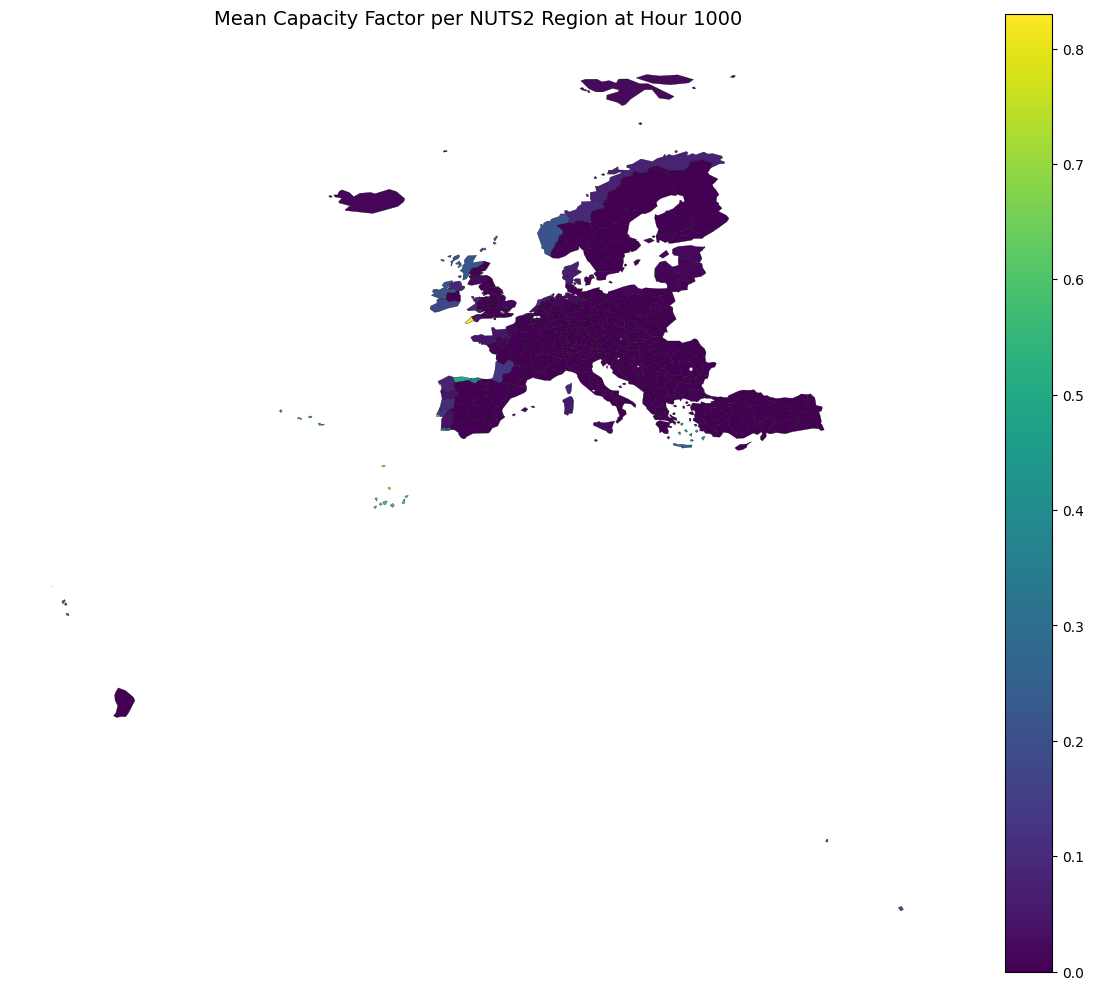

In [11]:
import matplotlib.pyplot as plt

# Choose the hour to visualize (e.g., 1000)
target_hour = 1000

# Filter the hourly data
cf_hour_df = cf_nuts2_hourly_df[cf_nuts2_hourly_df['hour'] == target_hour]

# Merge with NUTS2 shapes to prepare for plotting
nuts2_map_df = nuts2_polygons_gdf.merge(cf_hour_df, on='NUTS_ID')

# Plot the map
fig, ax = plt.subplots(figsize=(12, 10))
nuts2_map_df.plot(
    column='mean_cf',
    cmap='viridis',
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.2,
    missing_kwds={'color': 'lightgrey', 'label': 'No data'}
)

ax.set_title(f"Mean Capacity Factor per NUTS2 Region at Hour {target_hour}", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()
